In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import random
import math
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pyproteonet.data import Dataset

eval_columns = ['mindet', 'minprob', 'mean', 'knn', 'missforest', 'bpca', 'isvd', 'vae', 'dae', 'cf', 'iterative', 'gnn_imp']

# Load Datasets

In [5]:
from preprocessing import embed_sequences_t5_cached, create_masked_dataset, remove_all_missing
imp_datasets = {}

for ds_name in ['maxlfqbench']:
    print(ds_name)
    ds = Dataset.load(f'data/datasets_imputed/{ds_name}')
    imp_datasets[ds_name] = ds

maxlfqbench


In [36]:
from pyproteonet.metrics.abundance_comparison import compare_columns
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import boxplot

from pyproteonet.metrics.paired_testing import paired_wilcoxon_matrix

/tmp/ipykernel_857523/2469375740.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_857523/2469375740.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_857523/2469375740.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/132 [00:00<?, ?it/s]

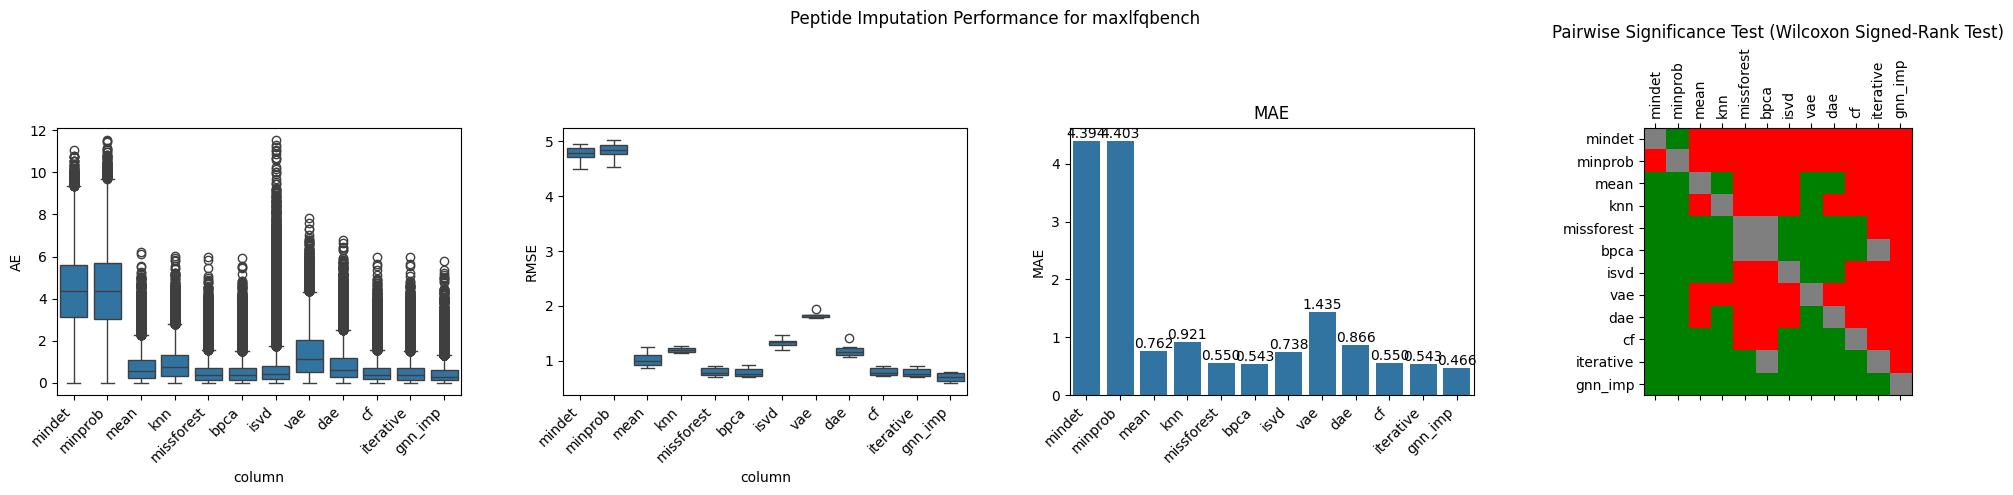

In [37]:
for ds_name, ds in imp_datasets.items():
    not_all_missing = ds.get_wf('peptide', 'abundance')
    not_all_missing = not_all_missing[not_all_missing.count(axis=1) > 0].index
    gt_column = 'abundance_gt'
    ids = ds.values['peptide'][gt_column]
    ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
    ids = ids[ids.get_level_values('id').isin(not_all_missing)]
    df= ds.values['peptide'].df.loc[ids, eval_columns]
    df = df[~df.isna().any(axis=1)]
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs = axs.flatten()
    # molecule AE and sample wise RMSE plots
    fig.suptitle(f'Peptide Imputation Performance for {ds_name}')
    for metric, ax in zip(['AE', 'RMSE'], axs):
        metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                    metric=metric, logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
        boxplot(data=metric_df, x='column', y='metric', ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # Dataset AE barplot 
    df = ds.values['peptide'].df
    df = df.loc[ids]
    ae = ((df - df[[gt_column]].values).abs())
    ae = ae[eval_columns]
    mae = ae.mean()
    ax = axs[2]
    sns.barplot(mae, ax=ax)
    ax.set_xticklabels(mae.index, rotation=45, ha='right')
    ax.bar_label(ax.containers[0], fontsize=10, fmt='%.3f')
    ax.set_ylabel('MAE')
    ax.set_title('MAE')
    #print(((df - df[[gt_column]].values)**2).mean())
    paired_wilcoxon_matrix(dataset=ds, molecule='peptide', eval_columns=eval_columns, gt_column=gt_column, ax=axs[3], ids=ids)
    axs[3].set_title('Pairwise Significance Test (Wilcoxon Signed-Rank Test)')
    fig.tight_layout()

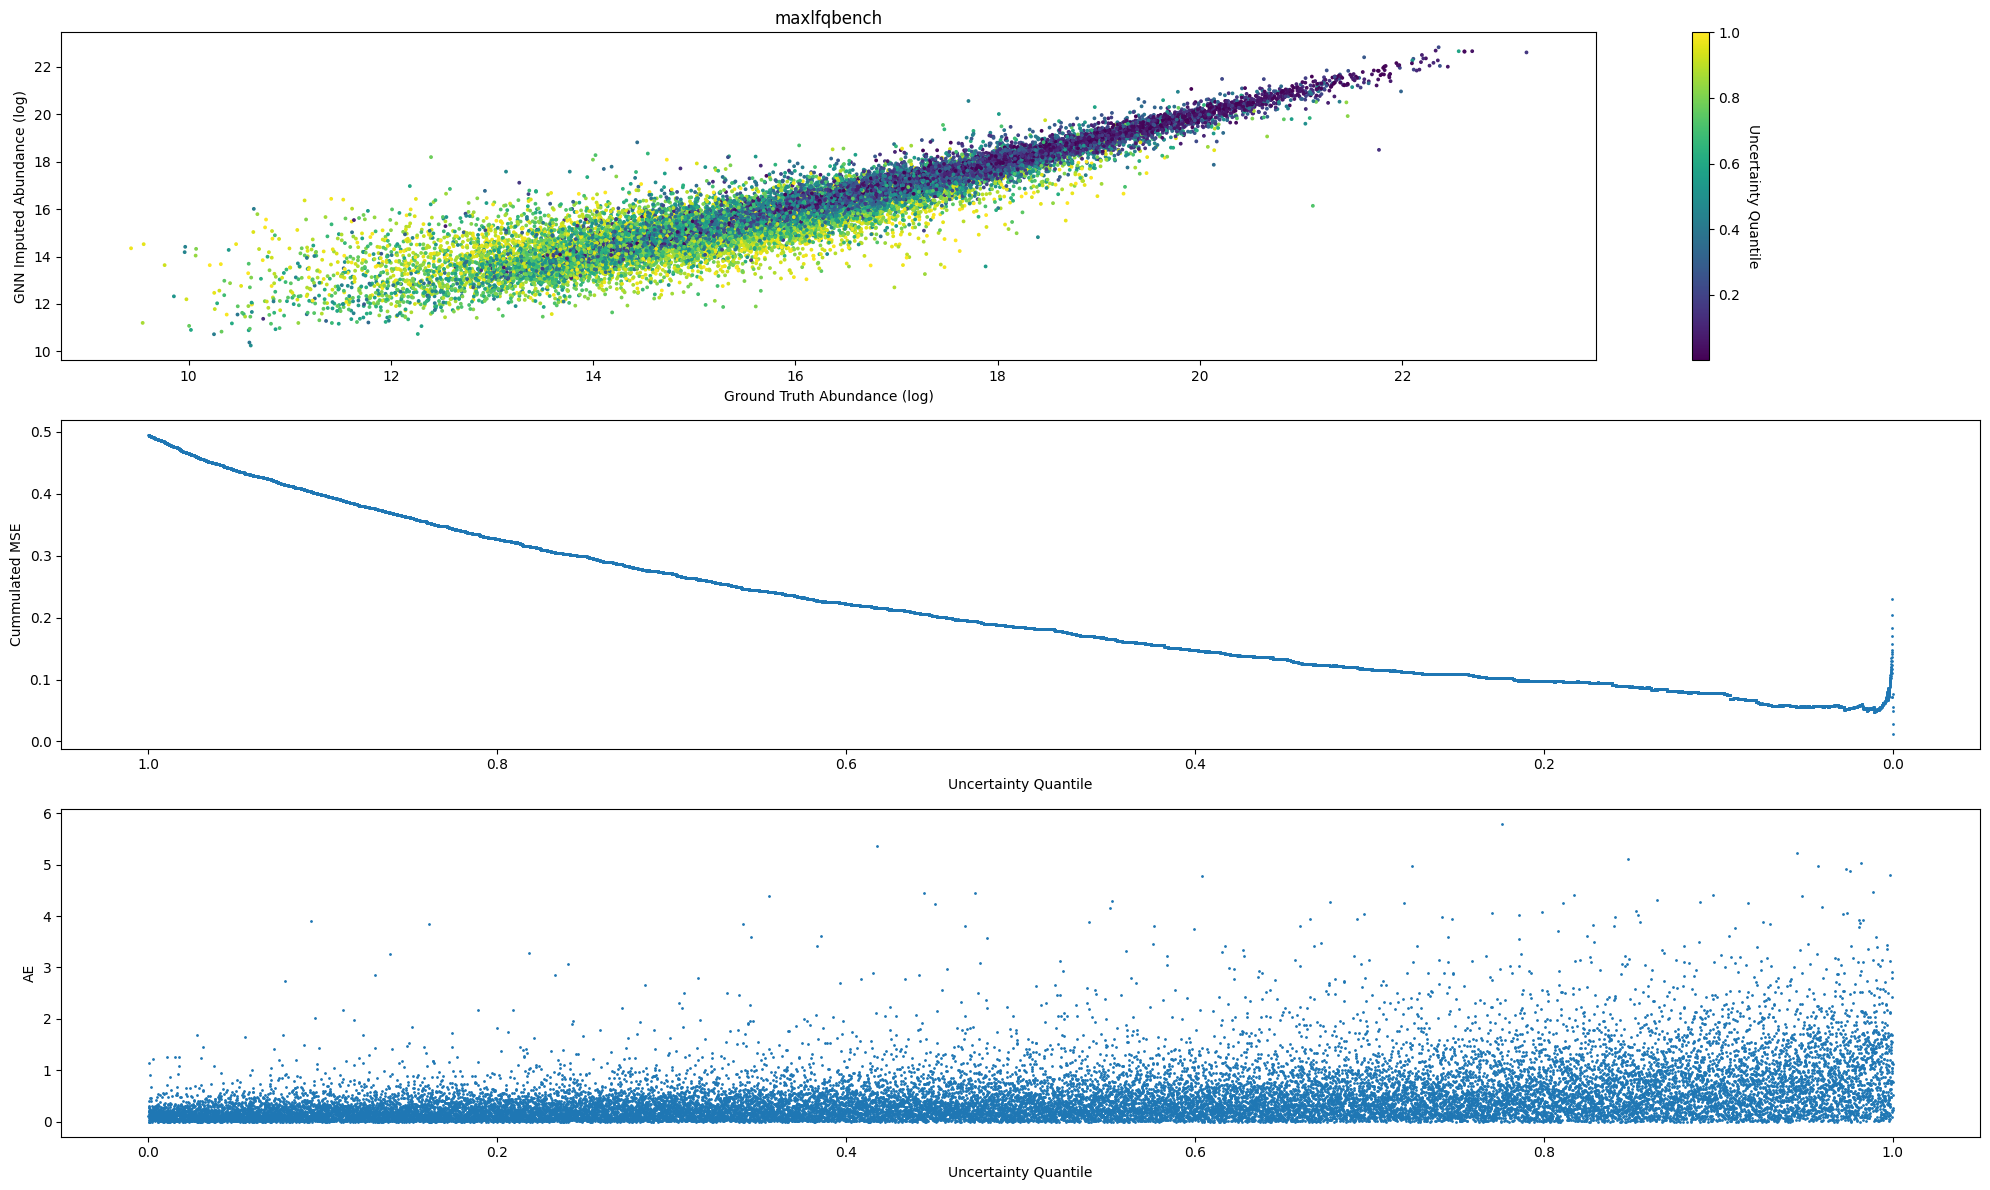

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
fig, axs = plt.subplots(3, len(imp_datasets), figsize=(20, 12))
axs = axs.transpose().flatten()
for i, (ds_name, ds) in enumerate(imp_datasets.items()):
    df = ds.values['peptide'].df
    gt_column = 'abundance_gt'
    gt =df[gt_column]
    mask = df['abundance'].isna() &  ~gt.isna()
    gt = gt[mask]
    gnn = df[f'gnn_imp']
    gnn = gnn[mask]
    uncertainty = df[f'gnn_imp_var']
    uncertainty = uncertainty[mask]
    diff = (gt - gnn).abs()
    se  = (gt - gnn)**2
    df = pd.DataFrame({'gt':gt, 'gnn':gnn, 'ae':diff, 'se':se, 'uncertainty':uncertainty})
    df['ae_rank'] = df.ae.rank()
    df['uncertainty_rank'] = df.uncertainty.rank() / df.shape[0]
    ax = axs[3 * i]
    mappable = ax.scatter(gt, gnn, c=df.uncertainty_rank, s=3)
    #mappable = ax.scatter(np.abs(gt-gnn), np.log(uncertainty), s=5)
    #ax.set_title(f'{ds_name_map[ds_name]}, {agg} aggregation')
    ax.set_xlabel('Ground Truth Abundance (log)')
    ax.set_ylabel('GNN Imputed Abundance (log)')
    cbar = plt.colorbar(mappable=mappable)
    cbar.set_label('Uncertainty Quantile', rotation=-90, verticalalignment='bottom')
    df = df.sort_values('uncertainty', ascending=True)
    df['mae'] = df['ae'].cumsum() / np.arange(1, df.shape[0]+1)
    df['mse'] = df['se'].cumsum() / np.arange(1, df.shape[0]+1)
    ax.set_title(ds_name)
    ax = axs[3 * i + 1]
    ax.scatter(df.uncertainty_rank, df['mse'], s=1)
    ax.set_xlim(ax.get_xlim()[::-1])
    #ax.scatter(df['ae'], np.log(df['uncertainty']), s=1)
    ax.set_xlabel('Uncertainty Quantile')
    ax.set_ylabel('Cummulated MSE')

    ax = axs[3 * i + 2]
    ax.scatter(df.uncertainty_rank, df['ae'], s=1)
    ax.set_xlabel('Uncertainty Quantile')
    ax.set_ylabel('AE')
    #ax.scatter(df['ae'], np.log(df['uncertainty']), s=1)
    ax.set_xlabel('Uncertainty Quantile')
    #mappable = ax.scatter(df['gt'].loc[ids], df.gnn.loc[ids], c=np.log(df.uncertainty.loc[ids]), s=1, cmap='inferno')
    #plt.colorbar(mappable)
fig.tight_layout()

In [7]:
from typing import Optional, List
from pyproteonet.metrics.differential_expression import find_des, evaluate_des
from pyproteonet.visualization.differential_expression import plot_des_volcano
import math
numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
fc_thresh = 1.5

from typing import Optional
def plot_eval_des(ds, molecule, columns, ref_column, numerator_samples, denominator_samples, save_dir=None, separate_figs: bool = False, 
                  groups: Optional[List[str]] = None, ylim=None):
    if not separate_figs:
        fig, axs = plt.subplots(2, 1, figsize=(12, 16))
        i=0
    if groups is not None:
        assert len(groups) == len(columns)
    if separate_figs:
        fig, axs = plt.subplots(1, 1, figsize=(20, 8))
        axs = [axs]
        i=0
    is_ecoli = ds.molecules[molecule].is_ecoli
    categories = pd.Series(index=is_ecoli.index, data='')
    categories.loc[is_ecoli] = 'E. coli'
    categories.loc[~is_ecoli] = 'Human'
    gt_fc = pd.Series(index=categories.index, data=1)
    gt_fc.loc[categories == 'E. coli'] = 3
    de_res = []
    res = evaluate_des(dataset=ds, molecule=molecule, columns=columns + [ref_column], numerator_samples=numerator_samples,
                       denominator_samples=denominator_samples, gt_fc=gt_fc,
                       min_fc=fc_thresh, max_pvalue=0.05, is_log=True, absolute_metrics=False)
    res['Method'] = res.index
    res['run'] = 0
    res.loc[:, ['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] = (res[['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] - res.loc[ref_column])
    de_res.append(res)
    de_res = pd.concat(de_res, ignore_index=True)
    #de_res.loc[:, ['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives']] = (de_res[['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives']] - de_res.loc['aggregated'])
    de_res.rename(columns={'F1 Score': 'F₁ Score'}, inplace=True)
    de_res = de_res.melt(id_vars=['Method'], value_vars=['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F₁ Score'], value_name='%', var_name='Metric')
    if groups is not None:
        groups_map = {c:g for c,g in zip(columns, groups)}
        de_res['Metric'] = de_res['Metric'] + ' ' + de_res['Method'].map(groups_map)
    #de_res['Method'] = de_res['Method'].map(column_label_map)
    #de_res = de_res.melt(id_vars=['Method'], value_vars=['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives'], value_name='%', var_name='Metric')
    ax = axs[i]
    sns.barplot(data=de_res, x='Method', y='%', hue='Metric', ax=ax)
    for con in ax.containers:
        ax.bar_label(con, fmt='%.3f')
    if i==0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True)
    else:
        ax.legend().remove()
    i+=1
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    fig.tight_layout()
    return de_res

/tmp/ipykernel_1095409/2901959704.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')


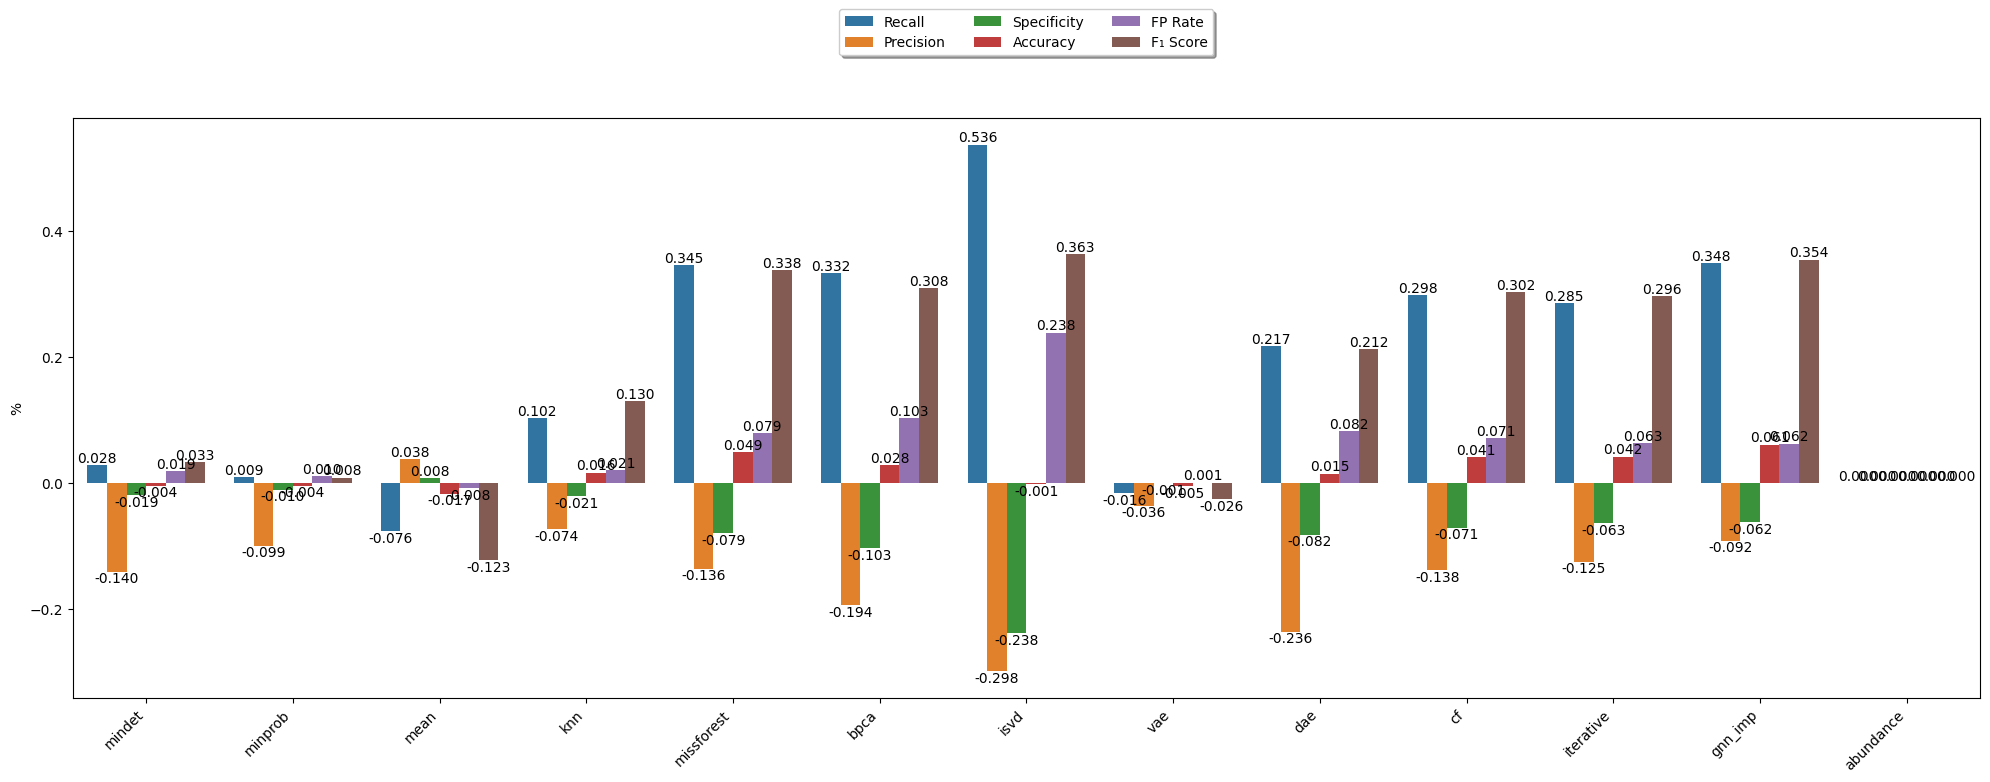

In [10]:
import seaborn as sns
de_res = plot_eval_des(ds=imp_datasets['maxlfqbench'], molecule='peptide', columns=eval_columns, ref_column='abundance',
                       numerator_samples=numerator_samples, denominator_samples=denominator_samples, save_dir=None, separate_figs=True, ylim=(-0.6, 0.4))

AUPRC mindet: 0.5193894063028137
AUPRC minprob: 0.5294248687342296
AUPRC mean: 0.6084591224487927
AUPRC knn: 0.6086593626028735
AUPRC missforest: 0.6344627435716019
AUPRC bpca: 0.6064096362765972
AUPRC isvd: 0.4615123323751327
AUPRC vae: 0.5726232474851933
AUPRC dae: 0.5536691482294473
AUPRC cf: 0.6176265658941773
AUPRC iterative: 0.6160157258643126
AUPRC gnn_imp: 0.6765011056145954


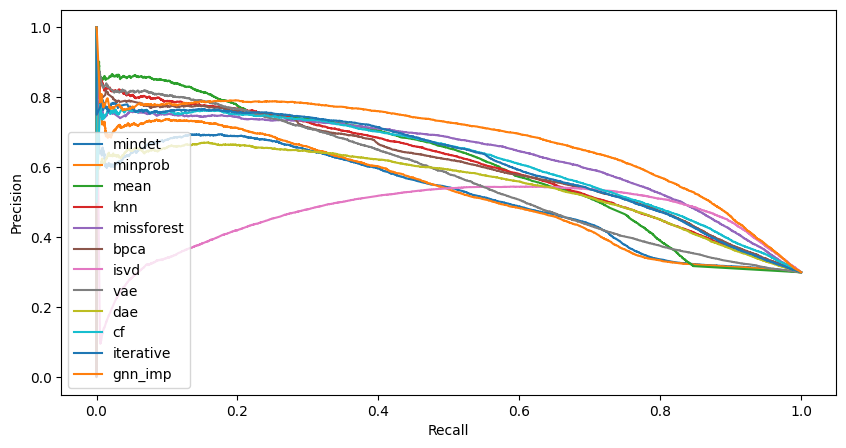

In [11]:
ds = imp_datasets['maxlfqbench']

des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=eval_columns,
                            nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                            min_fc=1, max_pvalue=0.05, is_log=True)
is_ecoli = ds.molecules['peptide'].is_ecoli
categories = pd.Series(index=is_ecoli.index, data='')
categories.loc[is_ecoli] = 'E. coli'
categories.loc[~is_ecoli] = 'Human'
gt_fc = pd.Series(index=categories.index, data=1)
gt_fc.loc[categories == 'E. coli'] = 3
gt_fc[gt_fc == 1] = 0
gt_fc[gt_fc == 3] = 1

from sklearn.metrics import precision_recall_curve, auc

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for c in pvalues.columns:
    precision, recall, thresholds = precision_recall_curve(y_true=gt_fc, probas_pred=1 - pvalues[c])
    ax.plot(recall, precision, label=c)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    print(f'AUPRC {c}: {auc(recall, precision)}')
ax.legend()